In [1]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve, select_threshold
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_data = pd.read_csv('train (modified)v2.csv')

In [3]:
train_data.head()

,,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Response2
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,8,1
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,4,0
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,8,1
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,8,1
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,8,1


In [4]:
# Data Preprocessing
# Investigating the dataset and handling of missing values
# 1) Understanding the behavior of the response variable. In here, label 1 is the lowest risk, label 8 being the highest. This is because the response variable is an ordinal variable.
#    We modified the dataset by adding another column "Response2" to categorize each observation into either "Eligible for AUW - 0" or "Not Eligible for AUW - 1".
# 2) Drop columns if it has too many empty cells. We set the threshold to 0.4. If a column contains more than 40% of missing values, we drop the
missing_rate = train_data.isnull().sum() / len(train_data)
missing_rate[missing_rate>0.4]
                                 


Insurance_History_5    0.427679
Family_Hist_2          0.482579
Family_Hist_3          0.576632
Family_Hist_5          0.704114
Medical_History_10     0.990620
Medical_History_15     0.751015
Medical_History_24     0.935990
Medical_History_32     0.981358
dtype: float64

In [5]:
train_data = train_data.drop(['Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_5', 'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32'], axis=1)



In [6]:
# 3) Fill in the rest of the empty values with column means.
train_data = train_data.fillna(train_data.mean())
# 4) Seperating train_data into data and label
X_data = train_data.drop(['Response', 'Response2'], axis=1)
y_label = train_data['Response2']

In [7]:
X_data = np.array(X_data)
y_label = np.array(y_label)

In [8]:
X_data = X_data[:, 1:]
X_data.shape

(59381, 118)

In [20]:
# Split X_data into training and test set 
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_label, test_size=0.4, random_state=0, stratify=y_label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)



In [37]:
catboost1 = CatBoostClassifier(eval_metric='AUC', cat_features=[1])
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
parameters = {'learning_rate': [0.03, 0.1],
              'depth': [4,6,10],
              'l2_leaf_reg': [1,3,5,7,9]}
randomized = catboost1.randomized_search(param_distributions=parameters, X=X_train, y=y_train, cv=10)


0:	test: 0.8029396	best: 0.8029396 (0)	total: 48.2ms	remaining: 48.2s
1:	test: 0.8175870	best: 0.8175870 (1)	total: 83.8ms	remaining: 41.8s
2:	test: 0.8356498	best: 0.8356498 (2)	total: 107ms	remaining: 35.6s
3:	test: 0.8422172	best: 0.8422172 (3)	total: 127ms	remaining: 31.7s
4:	test: 0.8468524	best: 0.8468524 (4)	total: 153ms	remaining: 30.5s
5:	test: 0.8458497	best: 0.8468524 (4)	total: 178ms	remaining: 29.4s
6:	test: 0.8460193	best: 0.8468524 (4)	total: 204ms	remaining: 29s
7:	test: 0.8465976	best: 0.8468524 (4)	total: 226ms	remaining: 28s
8:	test: 0.8492557	best: 0.8492557 (8)	total: 254ms	remaining: 27.9s
9:	test: 0.8507798	best: 0.8507798 (9)	total: 293ms	remaining: 29s
10:	test: 0.8517209	best: 0.8517209 (10)	total: 376ms	remaining: 33.8s
11:	test: 0.8526853	best: 0.8526853 (11)	total: 414ms	remaining: 34.1s
12:	test: 0.8541233	best: 0.8541233 (12)	total: 438ms	remaining: 33.2s
13:	test: 0.8552541	best: 0.8552541 (13)	total: 463ms	remaining: 32.6s
14:	test: 0.8560494	best: 0.85

In [74]:
# Based on randomized search results
Catboost_best = CatBoostClassifier(eval_metric='AUC', cat_features=[1], depth=10, l2_leaf_reg=3, learning_rate=0.03)
Catboost_best.fit(X_train, y_train, 
          eval_set=(X_val, y_val), cat_features = [1])
prediction_best = Catboost_best.predict(X_test)
prediction_best

0:	test: 0.8372727	best: 0.8372727 (0)	total: 184ms	remaining: 3m 3s
1:	test: 0.8545794	best: 0.8545794 (1)	total: 357ms	remaining: 2m 58s
2:	test: 0.8586886	best: 0.8586886 (2)	total: 631ms	remaining: 3m 29s
3:	test: 0.8615160	best: 0.8615160 (3)	total: 950ms	remaining: 3m 56s
4:	test: 0.8633751	best: 0.8633751 (4)	total: 1.13s	remaining: 3m 45s
5:	test: 0.8646827	best: 0.8646827 (5)	total: 1.38s	remaining: 3m 48s
6:	test: 0.8662696	best: 0.8662696 (6)	total: 1.59s	remaining: 3m 46s
7:	test: 0.8677366	best: 0.8677366 (7)	total: 1.99s	remaining: 4m 7s
8:	test: 0.8685729	best: 0.8685729 (8)	total: 2.29s	remaining: 4m 12s
9:	test: 0.8677845	best: 0.8685729 (8)	total: 2.49s	remaining: 4m 6s
10:	test: 0.8677412	best: 0.8685729 (8)	total: 2.76s	remaining: 4m 8s
11:	test: 0.8680965	best: 0.8685729 (8)	total: 3.1s	remaining: 4m 15s
12:	test: 0.8689541	best: 0.8689541 (12)	total: 3.33s	remaining: 4m 12s
13:	test: 0.8697336	best: 0.8697336 (13)	total: 3.63s	remaining: 4m 15s
14:	test: 0.8697935

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
catboost1 = CatBoostClassifier(eval_metric='AUC', cat_features=[1])
catboost1.fit(X_train, y_train, 
          eval_set=(X_val, y_val), cat_features = [1])

prediction = catboost1.predict(X_test)
prediction

Learning rate set to 0.076595
0:	test: 0.8337980	best: 0.8337980 (0)	total: 59.1ms	remaining: 59.1s
1:	test: 0.8399650	best: 0.8399650 (1)	total: 100ms	remaining: 50.1s
2:	test: 0.8545762	best: 0.8545762 (2)	total: 148ms	remaining: 49.1s
3:	test: 0.8573969	best: 0.8573969 (3)	total: 193ms	remaining: 48.2s
4:	test: 0.8607606	best: 0.8607606 (4)	total: 273ms	remaining: 54.3s
5:	test: 0.8613136	best: 0.8613136 (5)	total: 399ms	remaining: 1m 6s
6:	test: 0.8634706	best: 0.8634706 (6)	total: 463ms	remaining: 1m 5s
7:	test: 0.8646460	best: 0.8646460 (7)	total: 571ms	remaining: 1m 10s
8:	test: 0.8651226	best: 0.8651226 (8)	total: 641ms	remaining: 1m 10s
9:	test: 0.8661086	best: 0.8661086 (9)	total: 706ms	remaining: 1m 9s
10:	test: 0.8672253	best: 0.8672253 (10)	total: 795ms	remaining: 1m 11s
11:	test: 0.8679844	best: 0.8679844 (11)	total: 849ms	remaining: 1m 9s
12:	test: 0.8687138	best: 0.8687138 (12)	total: 915ms	remaining: 1m 9s
13:	test: 0.8697174	best: 0.8697174 (13)	total: 1s	remaining: 1

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
len(y_train[y_train==0])

19119

In [23]:
len(y_train[y_train==1])

16509

In [267]:
#grid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}
#gridsearch = GridSearchCV (estimator = catboost1, param_grid = grid, scoring ='accuracy', cv = 5)

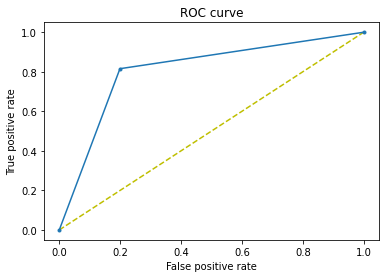

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [69]:
pooling = Pool(X_train, y_train, cat_features=[1])
roc = get_roc_curve(catboost1, pooling)
boundary = select_threshold(catboost1, 
                            curve=roc,  
                            FPR=0.01)
boundary

0.8722941791845698

In [70]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [75]:
# Prediction based on Randomized Search 
accuracy = 0
i=0
while i < len(y_test):
    if y_test[i] == prediction_best[i]:
        accuracy = accuracy + 1
    else:
        accuracy = accuracy
    i += 1
accuracy = accuracy/len(y_test)
accuracy


0.8079481350509388

In [78]:
# Prediction based on base Catboost model
accuracy = 0
i=0
while i < len(y_test):
    if y_test[i] == prediction[i]:
        accuracy = accuracy + 1
    else:
        accuracy = accuracy
    i += 1
accuracy = accuracy/len(y_test)
accuracy

0.8076113496674244

<AxesSubplot:>

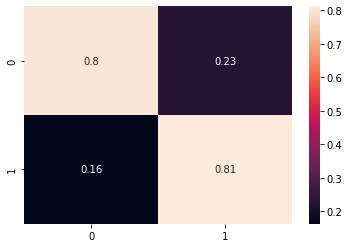

In [76]:
# Confusion matrix based on Randomized Search
cm = confusion_matrix(y_test, prediction_best)
cm2 = cm/cm.astype(np.float).sum(axis=1)
sns.heatmap(cm2, annot=True)

<AxesSubplot:>

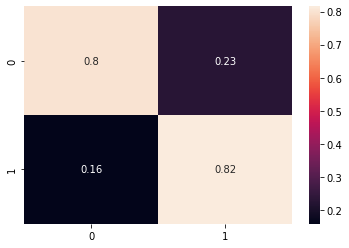

In [79]:
# Confusion matrix based on base Catboost model
cm = confusion_matrix(y_test, prediction)
cm2 = cm/cm.astype(np.float).sum(axis=1)
sns.heatmap(cm2, annot=True)

In [77]:
# Classification report based on Randomized Search
print(classification_report(y_test, prediction_best))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6373
           1       0.78      0.81      0.80      5504

    accuracy                           0.81     11877
   macro avg       0.81      0.81      0.81     11877
weighted avg       0.81      0.81      0.81     11877



In [80]:
# Classification report based on Catboost
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6373
           1       0.78      0.82      0.80      5504

    accuracy                           0.81     11877
   macro avg       0.81      0.81      0.81     11877
weighted avg       0.81      0.81      0.81     11877

